In [334]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from math import sqrt
from collections import Counter
from joblib import dump, load

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import silhouette_samples, silhouette_score

In [79]:
# Algumas configurações para o matplotlib.
from IPython.core.pylabtools import figsize
%matplotlib inline


figsize(12, 8)

sns.set()

In [2]:
market = pd.read_csv('estaticos_market.csv', index_col=0)

## Removendo dados faltantes acima de 5%

In [3]:
market_na = pd.DataFrame({
    'columns': market.columns,
    'types': market.dtypes,
    'nulls': market.isna().sum(),
    '% nulls': market.isna().sum() / market.shape[0]
})
market_na

,columns,types,nulls,% nulls
id,id,object,0,0.000000
fl_matriz,fl_matriz,bool,0,0.000000
de_natureza_juridica,de_natureza_juridica,object,0,0.000000
sg_uf,sg_uf,object,0,0.000000
natureza_juridica_macro,natureza_juridica_macro,object,0,0.000000
...,...,...,...,...
qt_funcionarios_24meses,qt_funcionarios_24meses,float64,358724,0.775958
tx_crescimento_12meses,tx_crescimento_12meses,float64,388410,0.840172
tx_crescimento_24meses,tx_crescimento_24meses,float64,388284,0.839900
tx_rotatividade,tx_rotatividade,float64,358724,0.775958


In [4]:
columns_na = market_na[market_na['% nulls'] > 0.1]['columns']

In [5]:
market.drop(columns=columns_na, inplace=True)

In [6]:
market.columns

Index(['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda',
       'dt_situacao', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm',
       'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'sg_uf_matriz', 'de_saude_tributaria', 'de_saude_rescencia',
       'nu_meses_rescencia', 'de_nivel_atividade', 'fl_simples_irregular',
       'fl_passivel_iss', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_estimado_grupo', 'vl_faturamento_estimado_aux',
       'vl_faturamento_estimado_grupo_aux', 'qt_filiais'],
      dtype='object')

## Aplicando `pandas-profiling` para analisar as features restantes

In [7]:
profile = ProfileReport(
    market, title='Market Profiling Report', explorative=True)

In [8]:
# profile.to_file('market.html')

## Analisando o relatório e tomando decisões de quais features devem ser removidas
* Features com alta cardinalidade
* Features com grande numeros de 0
* Mantendo as Macros e retirando as micros (alta correlação)
* Removendo as variaveis com baixa variabilidade
* Removendo dados categóricos que existem seu valor real

In [9]:
cardinality = ['de_natureza_juridica',
               'dt_situacao', 'nm_divisao']
market.drop(columns=cardinality, inplace=True)

In [10]:
correlation = ['de_ramo', 'sg_uf_matriz', 'vl_faturamento_estimado_grupo_aux']
market.drop(columns=correlation, inplace=True)

In [11]:
zeros = ['vl_total_veiculos_pesados_grupo',
         'vl_total_veiculos_leves_grupo', 'qt_filiais']
market.drop(columns=zeros, inplace=True)

In [12]:
categories = ['idade_emp_cat', 'de_saude_rescencia',
              'de_faixa_faturamento_estimado_grupo']
market.drop(columns=categories, inplace=True)

In [13]:
variability = market.var() < 7
variability = variability[variability == True].index
market.drop(columns=variability, inplace=True)

In [14]:
features = market.columns

## Tratando os dados nullos das features que foram selecionadas

In [15]:
market.isna().sum()

id                                   0
sg_uf                                0
natureza_juridica_macro              0
setor                             1927
idade_empresa_anos                   0
fl_rm                                0
nm_segmento                       1927
de_saude_tributaria              14851
nu_meses_rescencia               45276
de_nivel_atividade               11168
de_faixa_faturamento_estimado    27513
vl_faturamento_estimado_aux      27513
dtype: int64

In [16]:
imputer = dict()
imputer = {
    'setor': 'OUTROS',
    'nm_divisao': 'OUTROS',
    'nm_segmento': 'OUTROS',
    'nm_meso_regiao': 'OUTRAS',
    'de_saude_tributaria': 'OUTRO',
    'de_saude_rescencia': 'SEM INFORMACAO',
    'de_nivel_atividade': 'SEM INFORMACAO',
    'de_faixa_faturamento_estimado': 'SEM INFORMACAO',
    'de_faixa_faturamento_estimado_grupo': 'SEM INFORMACAO',
    'sg_uf_matriz': 'XX',
    'dt_situacao': 'SEM INFORMACAO'

}

In [17]:
market.fillna(imputer, inplace=True)

In [18]:
market.fillna(market.median(), inplace=True)

## Realizando um rank de features apos a analise exploratoria para melhor seleção
* Utilizando os portifolios já conhecidos

In [19]:
features_categorical = list(market.drop(
    columns=['id']).select_dtypes('object').columns)
features_numerics = list(market.select_dtypes('float64').columns)

In [20]:
port1 = pd.read_csv('estaticos_portfolio1.csv', usecols=market.columns)
portfolio2 = pd.read_csv('estaticos_portfolio2.csv', usecols=['id'])
portfolio3 = pd.read_csv('estaticos_portfolio3.csv', usecols=['id'])

In [21]:
port1.fillna(imputer, inplace=True)
port1.fillna(port1.median(), inplace=True)

In [22]:
port2 = pd.merge(portfolio2, market, on='id', how='inner')
port3 = pd.merge(portfolio3, market, on='id', how='inner')

In [23]:
port1['label'] = 0
port2['label'] = 1
port3['label'] = 2

In [24]:
portfolio = pd.concat([port1, port2, port3])
portfolio = portfolio.set_index(['id'])

In [25]:
X = portfolio.drop(columns=['label'])
y = portfolio['label']

In [26]:
le = LabelEncoder()
X[features_categorical] = X[features_categorical].apply(
    lambda col: le.fit_transform(col))

In [28]:
rf = RandomForestClassifier()
rf = rf.fit(X, y)

rfe = RFE(rf, n_features_to_select=1, verbose=2)
rfe = rfe.fit(X, y)

rank = pd.DataFrame({'features': X.columns})
rank['RF rank'] = rfe.ranking_

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [29]:
features = list(rank.sort_values('RF rank', ascending=True)['features'].head(6))
features

['vl_faturamento_estimado_aux',
 'idade_empresa_anos',
 'de_faixa_faturamento_estimado',
 'setor',
 'nm_segmento',
 'de_nivel_atividade']

## Criação do Pipeline de pre processamento
* Para features númericas usaremos `log`
* Para features categóricas usaremos `One Hot Encoder`
* Após as transformação aplicaremos redução de dimensionalidade `PCA`

In [31]:
features_categorical = list(market[features].select_dtypes('object').columns)
features_numerics = list(market[features].select_dtypes('float64').columns)

In [199]:
transformer_numeric = Pipeline(steps=[
    ('Log', FunctionTransformer(np.log1p))
])

transformer_categorical = Pipeline(steps=[
    ('OneHot', OneHotEncoder(sparse=False))
])

transformer = ColumnTransformer(
    transformers=[
        ('Numeric', transformer_numeric, features_numerics),
        ('Categorical', transformer_categorical, features_categorical),
    ]
)

preprocess = Pipeline(steps=[
    ('Tranform', transformer),
    ('PCA', PCA(n_components=0.95))
])

In [200]:
pipe_preprocess = preprocess.fit(market[features])

In [201]:
X_train = pipe_preprocess.transform(market[features])

## Verificando o método *Elbow* para selecionar o melhor numero de clusters

In [35]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=30,
                    random_state=42)
    kmeans.fit(X_train)
    
    wcss.append(kmeans.inertia_)

**Somas dos quadrados para cada quantidade de clusters que calculamos acima**

In [36]:
x1, y1 = 2, wcss[0]
x2, y2 = 20, wcss[len(wcss)-1]

distances = []
for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - de_faixa_faturamento_estimadoy2*x1)
    denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
    
    distances.append(numerator/denominator)

best_n = distances.index(max(distances)) + 2

print(f'Melhor numero de clusters: {best_n} ')

Melhor numero de clusters: 7 


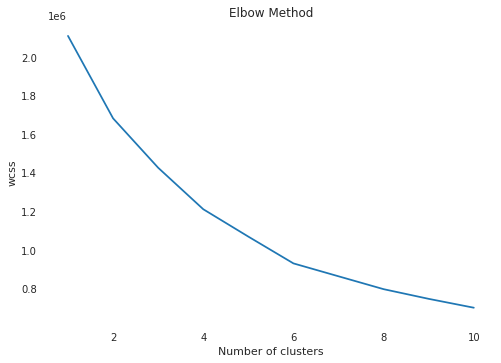

In [37]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

## Treinando o modelo de acordo com numéro de cluster apontado acima

In [202]:
kmeans = KMeans(n_clusters=7, max_iter=300, n_init=30, random_state=42)
kmeans.fit(X_train)
market['label'] = kmeans.labels_

In [203]:
market['label'].value_counts()

0    103726
1     98459
4     93116
3     63020
2     55243
5     47561
6      1173
Name: label, dtype: int64

In [204]:
market['label'].count()

462298

**Verificando a separação dos dados**

<IPython.core.display.Javascript object>


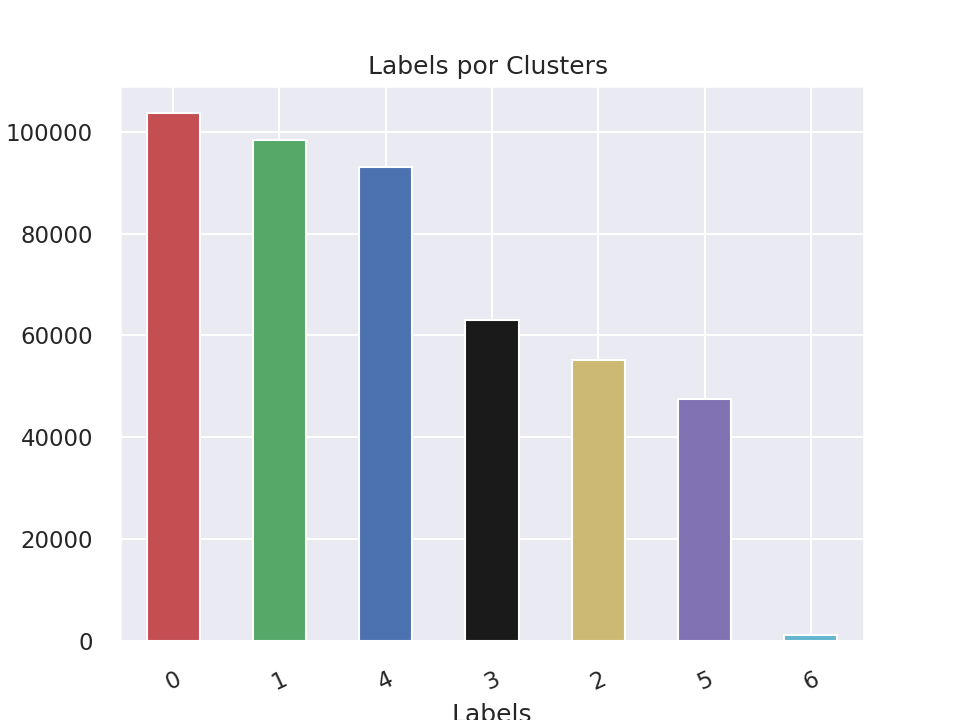

In [207]:
%matplotlib notebook
prob = market['label'].value_counts()
prob.plot(kind='bar', color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xlabel('Labels')
plt.title('Labels por Clusters ')
plt.xticks(rotation=25)
plt.show()

## Criação de funções para validação do modelo

In [185]:
def validate_model(port, features):
    X_train, X_test, y_train, y_test = train_test_split(port.drop(columns='label'), port['label'],
                                                    test_size=0.3,
                                                    random_state=0)
    X_train = pipe_preprocess.transform(X_train[features])
    
    pred = kmeans.predict(X_train)
    common = Counter(pred).most_common()
    
    labels = []
    if common[0][1] >= len(pred / 2):
        labels.append(common[0][0])
    else:
        labels.append(common[0][0])
        labels.append(common[1][0]) 
        
    recomendation = market[market['label'].isin(labels)]
    total = X_test['id'].count()
    
    predictions = pd.merge(X_test, recomendation, on='id',
                       how='inner')['id'].count()

    return (predictions / total * 100), labels, pred, X_train

In [232]:
def cluster_graph(X, centers, pred):
    %matplotlib notebook
    plt.scatter(X[pred == 0, 0],
                X[pred == 0, 2], s=50, color=['r'], label='label2')
    plt.scatter(X[pred == 1, 0],
                X[pred == 1, 2], s=50, color=['g'], label='label2')
    plt.scatter(X[pred == 2, 0],
                X[pred == 2, 2], s=50, color=['b'], label='label3')
    plt.scatter(X[pred == 3, 0],
                X[pred == 3, 2], s=50, color=['w'], label='label4')
    plt.scatter(X[pred == 4, 0],
                X[pred == 4, 2], s=50, color=['y'], label='label5')
    plt.scatter(X[pred == 5, 0],
                X[pred == 5, 2], s=50, color=['m'], label='label6')
    plt.scatter(X[pred == 6, 0],
                X[pred == 6, 2], s=50, color=['c'], label='label7')
    plt.scatter(centers[:, 0], centers[:, 2], s=100,
                color=['k'], label='centroid')
    plt.legend
    plt.show()

**Grafico da distribuição com todos os dados do mercado**

<IPython.core.display.Javascript object>


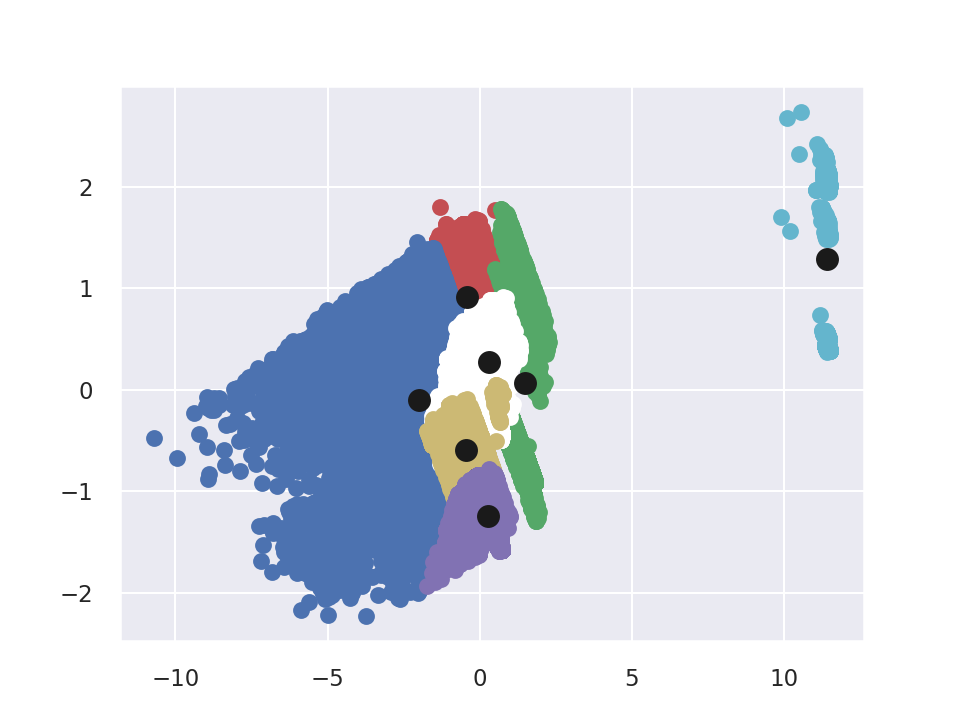

In [233]:
cluster_graph(X_train, kmeans.cluster_centers_, kmeans.labels_)

In [281]:
def percent_common(port, labels, column):
    recomendation = market[market['label'].isin(labels)][column]

    counter_recom = Counter(recomendation).most_common()
    counte_port = Counter(port[column]).most_common()

    percent_recom = counter_recom[0][1] / recomendation.shape[0] * 100
    column_recom = counter_recom[0][0]

    percent_port = counte_port[0][1] / port.shape[0] * 100
    column_port = counte_port[0][0]

    return column_port, round(percent_port,2), column_recom, round(percent_recom)

**Portifolio 1**

In [303]:
percet, labels, pred, X = validate_model(port1, features)
percet

70.65868263473054

In [304]:
columns = ['setor', 'de_faixa_faturamento_estimado', 'nm_segmento', 'de_nivel_atividade']

for column in columns:

    common = percent_common(port1, labels, column)
    print(column)
    print(
        f'Mais comum no porfólio é {common[0]} com um total de {common[1]}%')
    print(
        f'Mais comum nas recomendações é {common[2]} com um total de {common[3]}%')
    print('\n')

setor
Mais comum no porfólio é COMERCIO com um total de 89.37%
Mais comum nas recomendações é COMERCIO com um total de 73%


de_faixa_faturamento_estimado
Mais comum no porfólio é DE R$ 81.000,01 A R$ 360.000,00 com um total de 58.56%
Mais comum nas recomendações é ATE R$ 81.000,00 com um total de 51%


nm_segmento
Mais comum no porfólio é COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS com um total de 89.37%
Mais comum nas recomendações é COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS com um total de 73%


de_nivel_atividade
Mais comum no porfólio é MEDIA com um total de 50.45%
Mais comum nas recomendações é MEDIA com um total de 55%




<IPython.core.display.Javascript object>


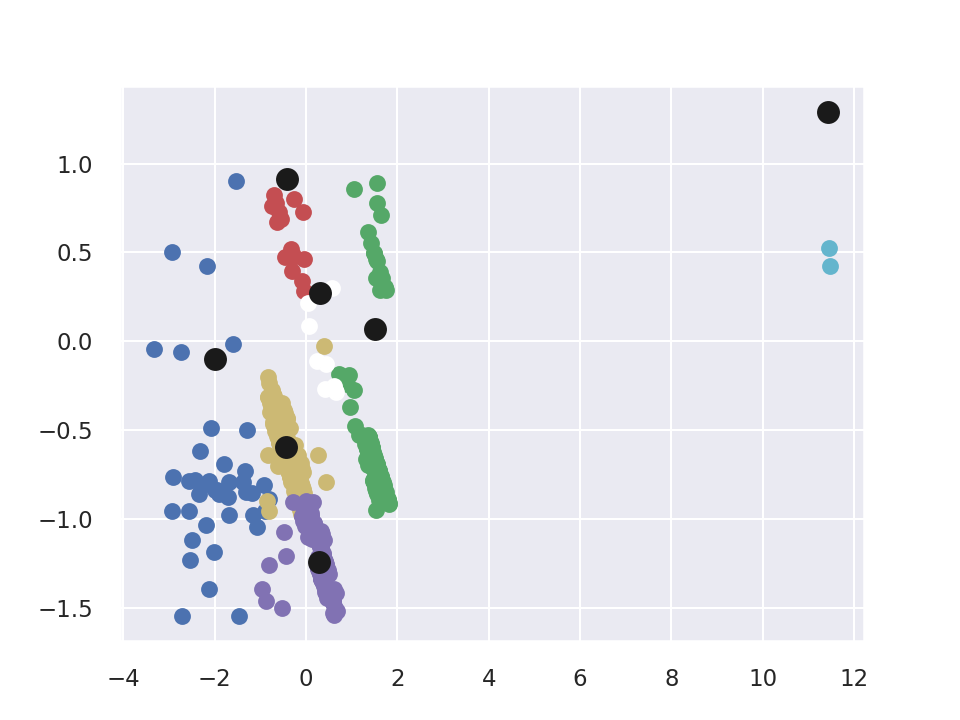

In [236]:
cluster_graph(X, kmeans.cluster_centers_, pred)

**Portifolio 2**

In [309]:
percet, labels, pred, X = validate_model(port2, features)
percet

100.0

In [310]:
columns = ['setor', 'de_faixa_faturamento_estimado', 'nm_segmento', 'de_nivel_atividade']

for column in columns:

    common = percent_common(port2, labels, column)
    print(column)
    print(
        f'Mais comum no porfólio é {common[0]} com um total de {common[1]}%')
    print(
        f'Mais comum nas recomendações é {common[2]} com um total de {common[3]}%')
    print('\n')

setor
Mais comum no porfólio é SERVIÇO com um total de 59.36%
Mais comum nas recomendações é SERVIÇO com um total de 44%


de_faixa_faturamento_estimado
Mais comum no porfólio é DE R$ 10.000.000,01 A R$ 30.000.000,00 com um total de 49.12%
Mais comum nas recomendações é DE R$ 360.000,01 A R$ 1.500.000,00 com um total de 73%


nm_segmento
Mais comum no porfólio é ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL com um total de 28.8%
Mais comum nas recomendações é COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS com um total de 42%


de_nivel_atividade
Mais comum no porfólio é ALTA com um total de 92.4%
Mais comum nas recomendações é ALTA com um total de 71%




<IPython.core.display.Javascript object>


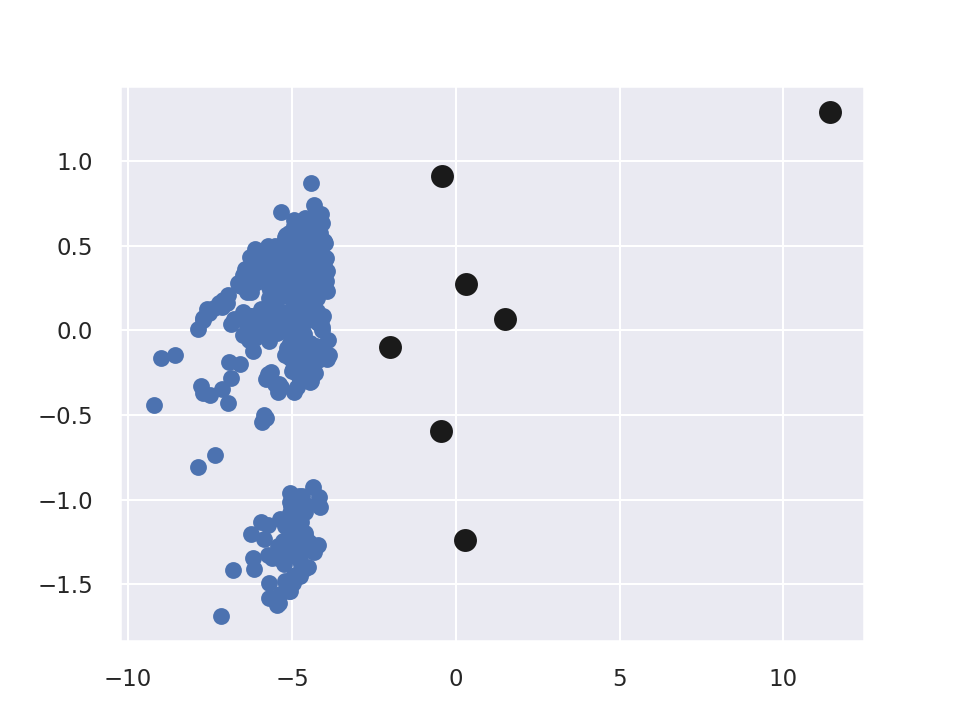

In [238]:
cluster_graph(X, kmeans.cluster_centers_, pred)

**Portifolio 3**

In [298]:
percet, labels, pred, X = validate_model(port3, features)
percet

100.0

In [312]:
columns = ['setor', 'de_faixa_faturamento_estimado', 'nm_segmento', 'de_nivel_atividade']

for column in columns:

    common = percent_common(port3, labels, column)
    print(column)
    print(
        f'Mais comum no porfólio é {common[0]} com um total de {common[1]}%')
    print(
        f'Mais comum nas recomendações é {common[2]} com um total de {common[3]}%')
    print('\n')

setor
Mais comum no porfólio é SERVIÇO com um total de 100.0%
Mais comum nas recomendações é SERVIÇO com um total de 44%


de_faixa_faturamento_estimado
Mais comum no porfólio é DE R$ 30.000.000,01 A R$ 100.000.000,00 com um total de 52.08%
Mais comum nas recomendações é DE R$ 360.000,01 A R$ 1.500.000,00 com um total de 73%


nm_segmento
Mais comum no porfólio é ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL com um total de 56.6%
Mais comum nas recomendações é COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS com um total de 42%


de_nivel_atividade
Mais comum no porfólio é ALTA com um total de 89.06%
Mais comum nas recomendações é ALTA com um total de 71%




<IPython.core.display.Javascript object>


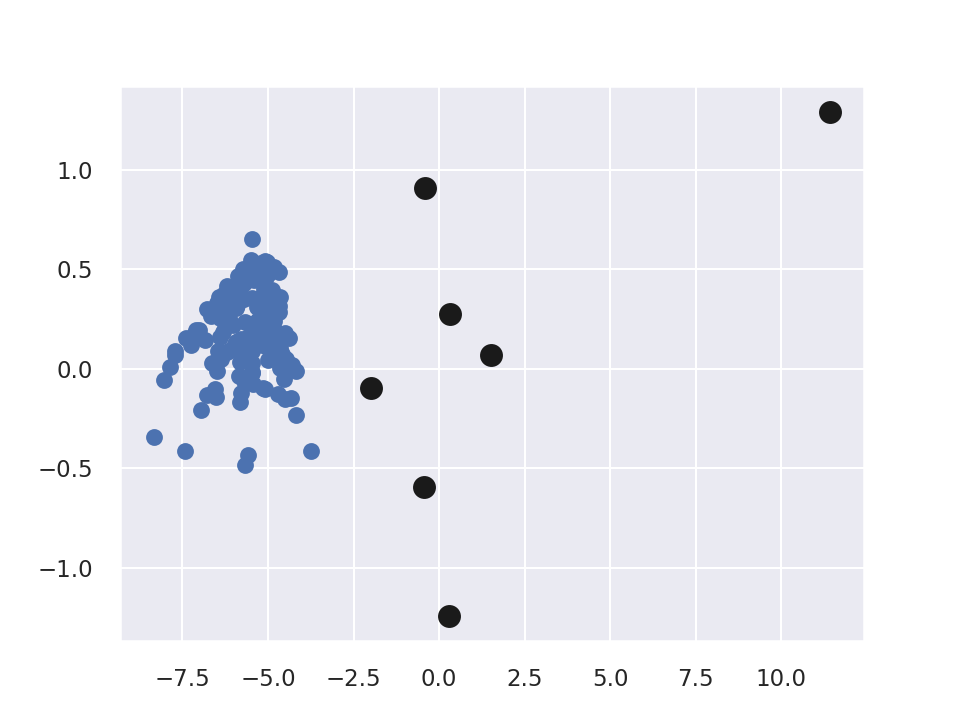

In [301]:
cluster_graph(X, kmeans.cluster_centers_, pred)

## Finalizando as analises e salvando os dados que serão usados no app

In [329]:
model = {'pipe': pipe_preprocess,
         'model': kmeans}

In [337]:
dump(model, 'modelo.pkl')

['modelo.pkl']

In [344]:
market.to_csv('market_label.csv')

In [358]:
port1.drop(columns='label').to_csv('port1.csv')

In [359]:
port2.drop(columns='label').to_csv('port2.csv')

In [360]:
port3.drop(columns='label').to_csv('port3.csv')

In [353]:
pd.DataFrame({'features': features}).to_csv('features.csv')